On va essayer de clenner les fichier par fichier et voir si y'a moyen d'améliorer ca

In [3]:
import pandas as pd
import numpy as np
import sys
import glob
import os
import math
import dask.dataframe as dd
import re
import heapq
import numpy as np
import shutil
import pyarrow.parquet as pq
from collections import defaultdict


In [44]:
parquet_folder = os.path.join(sys.path[0], "data_parquet")
parquet_folder_tracks = os.path.join(sys.path[0], "data_tracks_parquet")

all_files = glob.glob(os.path.join(parquet_folder, "*.parquet"))
all_track_files = glob.glob(os.path.join(parquet_folder_tracks, "*.parquet"))

# Trier les fichiers par le numéro de début de slice
def sort_key(f):
    m = re.search(r"mpd\.slice\.(\d+)-\d+\.parquet", f)
    return int(m.group(1)) if m else float('inf')

all_track_files = sorted(all_track_files, key=sort_key)

On fait un groupage intra fichier

In [ ]:

for i, file in enumerate(all_track_files):
    df = pd.read_parquet(file)
    # groupby local uniquement dans ce fichier
    grouped = (
            df.groupby("track_id").agg({
            "pid": list,             # fusionne la liste de pid
            "track_name": "first",   # garde la première occurrence
            "artist_name": "first"   # idem
        }).reset_index()
    )
    output_file = f"tracks_grouped/grouped_{i:04d}.parquet"
    grouped.to_parquet(output_file, index=False)
    if (i+1) % 100 == 0:
        print(f"Processed {i+1} files")


Processed 0 files
Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files


On va trier les musique intra fichier

In [48]:
import pyarrow.parquet as pq
import pyarrow as pa
import os

INPUT_DIR = "tracks_grouped"
TEMP_DIR = "temp_chunks"
os.makedirs(TEMP_DIR, exist_ok=True)

CHUNK_SIZE = 100_000  # nombre de lignes à traiter en mémoire par chunk

chunk_id = 0
for filename in os.listdir(INPUT_DIR):
    if not filename.endswith(".parquet"):
        continue
    table = pq.read_table(os.path.join(INPUT_DIR, filename))
    df = table.to_pandas()

    # Diviser en chunks si fichier très gros
    for start in range(0, len(df), CHUNK_SIZE):
        chunk = df.iloc[start:start + CHUNK_SIZE]
        # Tri en mémoire par track_id
        chunk = chunk.sort_values("track_id")
        # Sauvegarder chunk trié
        chunk_file = os.path.join(TEMP_DIR, f"chunk_{chunk_id:04d}.parquet")
        chunk.to_parquet(chunk_file, index=False)
        chunk_id += 1

print(f"{chunk_id} chunks créés dans {TEMP_DIR}")


1000 chunks créés dans temp_chunks


On trie les musiques interfichier

In [ ]:
TEMP_DIR = "temp_chunks"
OUTPUT_DIR = "track_vectors"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LINES_PER_FILE = 15_000  # lignes par fichier final
BUFFER_SIZE = 15_000       # écrire par lot pour performance

def parquet_row_generator(filename):
    for batch in pq.read_table(filename).to_batches():
        df = batch.to_pandas()
        for _, row in df.iterrows():
            yield row

chunk_files = [os.path.join(TEMP_DIR, f) for f in os.listdir(TEMP_DIR)]
generators = [parquet_row_generator(f) for f in chunk_files]
merged_iter = heapq.merge(*generators, key=lambda r: r["track_id"])

file_idx = 0
lines_in_file = 0
buffer = []

current_id = None
current_list = []

for row in merged_iter:
    tid = row["track_id"]
    lst = row["pid"] 
    art = row["artist_name"]
    name = row["track_name"] 
    if isinstance(lst, np.ndarray):
        lst = lst.tolist()

    if current_id is None:
        current_id = tid
        current_list = lst
        current_artist = art
        current_name = name
    elif tid == current_id:
        current_list.extend(lst)
    else:
        buffer.append({"track_id": current_id, "artist_name": current_artist, "track_name": current_name, "pid": current_list})
        lines_in_file += 1

        current_id = tid
        current_list = lst
        current_artist = art
        current_name = name
    if len(buffer) >= BUFFER_SIZE:
        file_path = os.path.join(OUTPUT_DIR, f"track_vector_{file_idx:04d}.parquet")
        if os.path.exists(file_path):
            # si le fichier existe déjà, créer un nouveau fichier
            file_idx += 1
            lines_in_file = 0
            file_path = os.path.join(OUTPUT_DIR, f"track_vector_{file_idx:04d}.parquet")
        table = pa.Table.from_pandas(pd.DataFrame(buffer))
        pq.write_table(table, file_path)
        buffer = []

    # changer de fichier si LINES_PER_FILE atteint
    if lines_in_file >= LINES_PER_FILE:
        file_idx += 1
        lines_in_file = 0

# écrire la dernière ligne
if current_id is not None:
    buffer.append({"track_id": current_id, "artist_name": current_artist, "track_name": current_name, "pid": current_list})

# écrire ce qui reste
if buffer:
    file_path = os.path.join(OUTPUT_DIR, f"track_vector_{file_idx:04d}.parquet")
    table = pa.Table.from_pandas(pd.DataFrame(buffer))
    pq.write_table(table, file_path)

print(f"Partitionnement terminé dans {OUTPUT_DIR}")


Partitionnement terminé dans track_vectors


Suprimes les dossiers intermédiaires

In [16]:
folder = os.path.join(sys.path[0], "temp_chunks")
if os.path.exists(folder):
    shutil.rmtree(folder)

folder = os.path.join(sys.path[0], "tracks_grouped")
if os.path.exists(folder):
    shutil.rmtree(folder)


Charge les fichiers track_vectors

In [113]:
parquet_folder_tracks = os.path.join(sys.path[0], "track_vectors")
df_tracks_vectors = dd.read_parquet(parquet_folder_tracks)
df_tracks_vectors = df_tracks_vectors.set_index("track_id", sorted= True)

On construit une indexation ce qui permet d'utiliser panda pour aller chercher seulement la db dont on a besoin

In [5]:
# index tous les fichiers track_vectors pour connaitre rapidement dans quel fichier chercher un track_id
def build_index(folder):
    index = []
    
    for filename in sorted(os.listdir(folder)):
        if not filename.endswith(".parquet"):
            continue
        
        path = os.path.join(folder, filename)
        
        # lire uniquement le row_group 0 (hyper rapide)
        table = pq.read_table(path, columns=["track_id"], read_dictionary=["track_id"])
        col = table.column("track_id")
        
        min_id = col[0].as_py()
        max_id = col[-1].as_py()
        index.append((min_id, max_id, filename))
    
    return index
INDEX = build_index(os.path.join(sys.path[0],"track_vectors"))

Permet d'utiliser panda et d'ouvrir le fichier dans lequel se trouve le track id

In [6]:
def find_file_for_track_id(track_id):
    low, high = 0, len(INDEX) - 1
    
    while low <= high:
        mid = (low + high) // 2
        min_id, max_id, filename = INDEX[mid]
        
        if track_id < min_id:
            high = mid - 1
        elif track_id > max_id:
            low = mid + 1
        else:
            return os.path.join(sys.path[0], "track_vectors", filename)
    return None

find_file_for_track_id('3Y6ILqXqCBNwBTxVda8Z68')


'c:\\Users\\ryanm\\Documents\\master big data\\info\\projet\\track_vectors\\track_vector_0068.parquet'

In [7]:
subset1 = df_tracks_vectors.loc[['3Y6ILqXqCBNwBTxVda8Z68','3Y6ILqXqCBNwBTxVda8Z68'], "pid"].compute()

In [8]:
def get_rows_in_order(df, track_ids):
    # un seul fetch Dask → compute()
    unique_ids = list(dict.fromkeys(track_ids))
    tmp = df.loc[unique_ids,'pid'].compute()

    # reconstruction dans l'ordre demandé
    rows = [tmp.loc[tid] for tid in track_ids]

    return rows
row = get_rows_in_order(df_tracks_vectors, ['3Y6ILqXqCBNwBTxVda8Z68','09bLMpxeUECNq4v5BIdgp6','3Y6ILqXqCBNwBTxVda8Z68'])

C'est la fonction principale elle permet de calculer les similarité entre musique ou playlist.
L'argument which permet de sélectionner si on choisit de calculer toutes les méthodes.

J'ai été assez surpris mais finalement c'est logique, que quand on utilise le produit avec la similarité du suprémum c'est long. La raison est qu'il faut faire une double boucle for sur la list pid de a et b. Cette liste peu potentiellement avoir une dizaine de millier d'items et donc la boucle peut qui en fait le carré peut être longue. c'est pas toujorus le cas mais c'est peu viable pour faire des stats descriptive.
Je proposerai d'enlever celui là pour les stats descritpive et juste de l'utiliser sur un micro échantillon

In [9]:
# Cette fonction évalue la similarité entre deux pistes en fonction des playlists dans lesquelles elles apparaissent.
# De plus on peut lui fournir une liste de pistes ce qui permet immédiatement de résoudre la question 4
def similar_tracks(track_id1, track_id2, which = 0):
    """" 
        track_id1 et track_id2 peuvent être des listes d'id ou des id simples
        which : 
            0 : retourne le score principal de facons optimisées (panda)
            1 : retourne le score principal et le score zoé calculés de façons optimisées (panda)
            2 : retourne le score principal, le score zoé et le score en utilisant dask 
            autre : retourne le score principal, le score zoé et le score en utilisant le max des similarités entre chaque paire de pistes
                    avec dask( computation plus lourde )
    """
    if isinstance(track_id1, list):
        try:
            # version panda:
            if(which == 1 or which == 0):
                file_to_id1 = defaultdict(list)
                file_to_id2 = defaultdict(list)

                for tid in track_id1 :
                    file_to_id1[find_file_for_track_id(tid)].append(tid)
                for tid in track_id2 :
                    file_to_id2[find_file_for_track_id(tid)].append(tid)

                pid_cache = {}   # track_id -> pid list
                list1,list2 = [], []
                for file, ids in file_to_id1.items():
                    df = pd.read_parquet(file,columns=["track_id", "pid"]).set_index("track_id")
                    list1 +=df.loc[file_to_id1[file],"pid"].iloc[:].explode().tolist()
                    list2 += df.loc[file_to_id2[file],"pid"].iloc[:].explode().tolist()
                    del file_to_id2[file]
                for file, ids in file_to_id2.items():
                    df = pd.read_parquet(file,columns=["track_id", "pid"]).set_index("track_id")
                    list2 += df.loc[file_to_id2[file],"pid"].iloc[:].explode().tolist()
            else:
                # version un peu moins naive avec un seul appel à dask
                # on peut faire mieux en utilisant pandas pour reconstruire les listes dans l'ordre demandé
                unique_ids = list(dict.fromkeys(track_id1+ track_id2))
                tmp = df_tracks_vectors.loc[unique_ids,'pid'].compute()
                # reconstruction dans l'ordre demandé
                rows = [tmp.loc[tid] for tid in track_id1 + track_id2] 
                list1 = [x for sub in rows[0:len(track_id1)] for x in sub]
                list2 = [x for sub in rows[len(track_id1):] for x in sub]     
            #Version très naive
            """
            #try:
            #    list1 = df_tracks_vectors.loc[track_id1, "pid"].compute().explode().tolist()
            #    list2 = df_tracks_vectors.loc[track_id2, "pid"].compute().explode().tolist()
            """
        except KeyError:
            print("Le numéro est out of range")
            return None
            
    else:
        ## partie où on utilise un seul track_id. On fait le calcul avec panda
        # on pourrait aussi optimiser si les deux musique sont dans le même fichier mais bon ca à a 1/150 chance d'arriver donc
        # flemme d'optimiser pour si peu
        try:
            # Récupérer les colonnes "list_pid"
            df = pd.read_parquet(find_file_for_track_id(track_id1),
                     columns=["track_id", "pid"])
            list1 = df.loc[df.track_id == track_id1, "pid"].iloc[0]
            df = pd.read_parquet(find_file_for_track_id(track_id2),
                     columns=["track_id", "pid"])
            list2 = df.loc[df.track_id == track_id2, "pid"].iloc[0]
            which = 0     # le calcul des autre ne prend du sens que si c'est une liste
        except KeyError:
            print("string")
            return None
    # transformer en sets pour intersection
    set1, set2 = set(list1), set(list2)
    n_common = len(set1 & set2)
    res_main = n_common / math.sqrt(len(set1) * len(set2))
    res_zoe = len(set(track_id1) & set(track_id2)) / math.sqrt(len(set(track_id1)) * len(set(track_id2)))
    if which == 0:
        return res_main
    if which == 1 or which == 2:
        return res_main, res_zoe
    else:
        res_sup = 0.0
        for l1 in rows[0:len(track_id1)]:
            sim = 0
            for l2 in rows[len(track_id1):]:
                sim = max(sim, len(set(l1) & set(l2)) /math.sqrt(len(set(l1)) * len(set(l2)) ))
                if sim == 1.0:
                    break
            res_sup = res_sup + sim
        res_sup = res_sup / (len(set(track_id1))*len(set(track_id2)))**0.5
        return (res_main, res_zoe, res_sup)

In [10]:
def get_track_ids_for_pid(n: int):
    if not (0 <= n <= 10**6):
        raise ValueError("n doit être entre 0 et 1_000_000 inclus.")
    # Calcul du range
    x = (n // 1000) * 1000
    y = x + 999
    filename = f"mpd.slice.{x}-{y}.parquet"
    # Lecture du fichier parquet
    filepath = os.path.join(sys.path[0], "data_tracks_parquet", filename)
    df = pd.read_parquet(filepath)

    # Filtrer les lignes où pid == n
    filtered = df[df["pid"] == n]

    # Retourner la colonne track_id comme liste
    return filtered["track_id"].tolist()

    

In [58]:
print(similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),2))
print(similar_tracks(get_track_ids_for_pid(2000),get_track_ids_for_pid(2000),2))

(0.1998485668390489, 0.0, 0.028675636963277677)
(1.0, 1.0, 1.0)


In [16]:
similar_tracks('3Y6ILqXqCBNwBTxVda8Z68','3Y6ILqXqCBNwBTxVda8Z68')


1.0

In [17]:
print(similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921)))
#print(similar_tracks(get_track_ids_for_pid(2000),get_track_ids_for_pid(2000)))


0.1998485668390489


## Comparaison des versions par rapport à dask ou panda
Ce serait bien de faire une comparaison temporelle et de la joindre dans le rapport
en lancant le code suivant ca vous donnera une idée de l'amélioration de l'une par rapport à l'autre

In [68]:
import time
start_time = time.time()
opt = similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),1)
end_time = time.time()
topt = end_time - start_time

start_time = time.time()
nopt = similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),2)
end_time = time.time()
tnopt = end_time - start_time

start_time = time.time()
all = similar_tracks(get_track_ids_for_pid(78561),get_track_ids_for_pid(235921),3)
end_time = time.time()
tall = end_time - start_time

print(f"Optimized time: {topt:.4f} seconds, result: {opt}")
print(f"Non-optimized time: {tnopt:.4f} seconds, result: {nopt}")
print(f"All method time: {tall:.4f} seconds, result: {all}")    

Optimized time: 1.3993 seconds, result: (0.1998485668390489, 0.0)
Non-optimized time: 2.6757 seconds, result: (0.1998485668390489, 0.0)
All method time: 4.2497 seconds, result: (0.1998485668390489, 0.0, 0.028675636963277677)


In [95]:
start_time = time.time()
opt = similar_tracks("2qz7JxLJ7lVeWSVOEq6bqF","2qz7JxLJ7lVeWSVOEq6bqF",3)
end_time = time.time()
topt = end_time - start_time
print(f"Optimized time: {topt:.4f} seconds, result: {opt}")

Optimized time: 0.0526 seconds, result: 1.0


Evaluation de la similarity entre n random tracks

In [34]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import glob

def sample_parquet_rows(path_pattern, k):
    df_list = []

    files = glob.glob(path_pattern)

    for file in files:
        pq_file = pq.ParquetFile(file)

        # Lire uniquement la colonne track_id pour connaître la taille
        table_head = pq_file.read(columns=["track_id"])
        nrows = table_head.num_rows

        # On tire k indices aléatoires
        k_sample = min(k, nrows)
        idx = np.random.choice(nrows, size=k_sample, replace=False)

        # Lire tout le fichier en pandas (15k lignes → très rapide)
        df = pq_file.read().to_pandas()

        # Ne garder que les lignes tirées au hasard
        df_sample = df.iloc[idx]

        df_list.append(df_sample)

    return pd.concat(df_list, ignore_index=True)


In [39]:
np.random.seed(1)
df_sample = sample_parquet_rows(
    "c:/Users/ryanm/Documents/master big data/info/projet/track_vectors/track_vector_*.parquet",
    k=300
)


In [40]:
df_sample

,track_id,artist_name,track_name,pid
0,01alUm0gSx3MX7j38agOcX,MPH,With My Crew,[373254]
1,02DPlcBHSz86pkbsYcSQJu,Sukhwinder Singh & Wajid,Hud Hud Dabangg,"[367160, 818484, 964991]"
2,00u3tGTApuvoDpfU3QgkJ5,Twin Peaks,Making Breakfast - Live,"[582515, 709573]"
3,015pnifiQH4uyoXdYXQ1Ob,daigoro789,Setsuko & Seita (Main Theme): Grave of the Fir...,"[345937, 823762]"
4,007PUucx7EWGWji9mU5vlM,Gadiel Espinoza,Las Bodas Del Cordero,"[36993, 137380, 165850, 946059]"
...,...,...,...,...
45295,7zumuTMPVN8STB9B5IRLS4,Andrea Jung und die Hasenkinder,Süßer die Glocken nie klingen,[462762]
45296,7yq8yE6yls9ZaFZGpdaoOp,Lee Ritenour,Stone Cool,[285349]
45297,7yyjtwLQJdYFVmNCR7WS0s,Josh Lekas,Time for Love,[179243]
45298,7yzc0gZo7cZvXy4WAHSXED,Gomba Jahbari,Si Tu Me Quieres (Dub),"[287707, 363098, 912810]"


In [43]:
sets = [set(x) for x in df_sample["pid"]]
n = len(sets)
k = 5  # exemple : tirer 5 paires aléatoires par ligne
list_nk = np.zeros(n*k, dtype=float)
for i in range(n):
    if(i%10000 == 0):
        print(i)
    Ai = sets[i]
    lenAi = len(Ai)
    # Tirer k indices aléatoires dans [0, n-1] sauf i
    choices = np.random.choice([x for x in range(n) if x != i], size=k, replace=False)
    for idx, j in enumerate(choices):
        Aj = sets[j]
        lenAj = len(Aj)

        inter = len(Ai & Aj)
        sim = inter / np.sqrt(lenAi * lenAj)
        list_nk[i*k + idx] = sim



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [44]:
np.mean(list_nk)

np.float64(3.004663346769538e-05)

In [56]:
len(list_nk)

226500

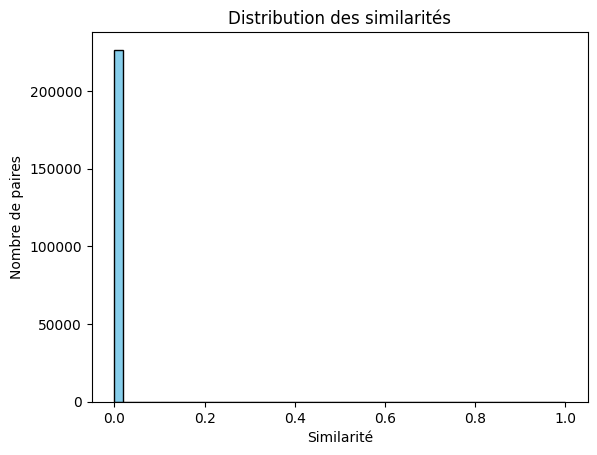

In [53]:
import matplotlib.pyplot as plt

plt.hist(list_nk, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Similarité")
plt.ylabel("Nombre de paires")
plt.title("Distribution des similarités")
plt.show()


In [66]:
N = 10  # nombre de tracks à récupérer

# Ajouter une colonne avec la longueur des pid
df_sample["pid_len"] = df_sample["pid"].apply(len)

# Trier par longueur décroissante et récupérer les N premiers track_id
top_tracks = df_sample.sort_values("pid_len", ascending=False).head(N)["track_id"].tolist()

print(top_tracks)



['12REd1n8PeiHHWOh066tpr', '4CJVkjo5WpmUAKp3R44LNb', '7vFoFDWqTX0mHzLfrF1Cfy', '6YbhspuOar1D9WSSnfe7ds', '6b8Be6ljOzmkOmFslEb23P', '6MdqqkQ8sSC0WB4i8PyRuQ', '0Y0TOsE1q11qgbi7c5WZsG', '4r8lRYnoOGdEi6YyI5OC1o', '0fioLzGM8ngbD1w6fMmm45', '1LxKKYsJNPeBdOwdudsJzv']


In [69]:
df_sample.sort_values("pid_len", ascending=False).head(N)

,track_id,artist_name,track_name,pid,pid_len
6080,12REd1n8PeiHHWOh066tpr,Flume,Never Be Like You,"[34, 37, 71, 76, 105, 107, 215, 279, 360, 389,...",23720
24324,4CJVkjo5WpmUAKp3R44LNb,Lynyrd Skynyrd,Sweet Home Alabama,"[1, 45, 115, 119, 237, 243, 326, 331, 343, 343...",21998
44890,7vFoFDWqTX0mHzLfrF1Cfy,OMI,Cheerleader - Felix Jaehn Remix Radio Edit,"[42, 93, 123, 148, 150, 154, 268, 400, 437, 56...",18583
38122,6YbhspuOar1D9WSSnfe7ds,Snoop Dogg,"Young, Wild & Free (feat. Bruno Mars) - feat. ...","[42, 115, 121, 136, 161, 211, 246, 321, 411, 4...",18250
38369,6b8Be6ljOzmkOmFslEb23P,Bruno Mars,24K Magic,"[95, 176, 309, 321, 542, 782, 913, 1012, 1043,...",17508
37043,6MdqqkQ8sSC0WB4i8PyRuQ,Blackstreet,No Diggity,"[134, 290, 368, 504, 584, 676, 751, 858, 942, ...",14590
3157,0Y0TOsE1q11qgbi7c5WZsG,Meek Mill,R.I.C.O. (feat. Drake),"[37, 62, 173, 285, 439, 449, 523, 546, 559, 70...",12792
28330,4r8lRYnoOGdEi6YyI5OC1o,*NSYNC,Bye Bye Bye,"[134, 274, 355, 359, 396, 643, 812, 858, 990, ...",12216
4019,0fioLzGM8ngbD1w6fMmm45,Sam Smith,I'm Not The Only One,"[41, 247, 272, 279, 386, 396, 443, 460, 489, 6...",11981
7909,1LxKKYsJNPeBdOwdudsJzv,Yo Gotti,Down In the DM,"[37, 253, 335, 351, 389, 452, 559, 585, 642, 7...",10949


In [70]:
# Ajouter une colonne avec la longueur des pid
df_sample["pid_len"] = df_sample["pid"].apply(len)

# Statistiques descriptives classiques
stats = df_sample["pid_len"].describe()
print(stats)


count    45300.000000
mean        30.265651
std        352.256965
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      23720.000000
Name: pid_len, dtype: float64


In [74]:
compare_best = []

for i in range(len(top_tracks)):
    for j in range(i+1, len(top_tracks)):
        compare_best.append(similar_tracks(top_tracks[i], top_tracks[j]))


In [76]:
np.mean(compare_best)

np.float64(0.03644887921485863)

In [97]:
e1,e2,res,resz = [],[],[],[]
np.random.seed(256)
for i in range(1000):
    if(i%100 == 0 ): print(i)
    n1 = np.random.randint(0, 10**6)
    n2 = np.random.randint(0, 10**6)
    e1.append(n1)
    e2.append(n2)
    sim = similar_tracks(get_track_ids_for_pid(n1),get_track_ids_for_pid(n2),1)
    res.append(sim[0])
    resz.append(sim[1])

0
100
200
300
400
500
600
700
800
900


In [98]:
sim = similar_tracks(get_track_ids_for_pid(n1),get_track_ids_for_pid(n2),1)

In [96]:
sim[1]

0.0

In [99]:
np.mean(res)

np.float64(0.15735809196061076)

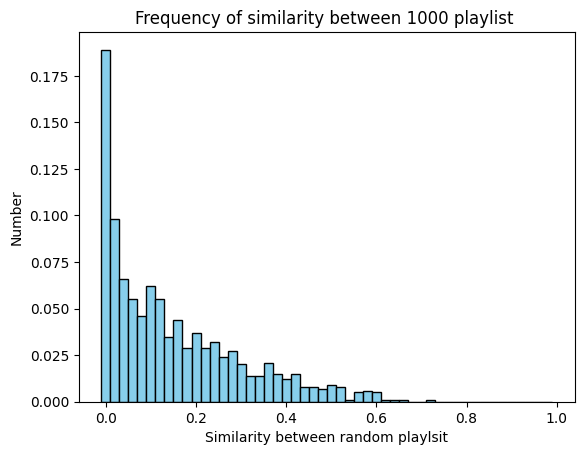

In [107]:
counts, bins = np.histogram(res, bins=50, range=(0,1))
prob = counts / counts.sum()  # fraction de points par barre

plt.bar(bins[:-1], prob, width=bins[1]-bins[0], color='skyblue', edgecolor='black')
plt.xlabel("Similarity between random playlsit")
plt.ylabel("Number")
plt.title("Frequency of similarity between 1000 playlist ")
plt.savefig("histogram_similarity.png", dpi=300)
plt.show()


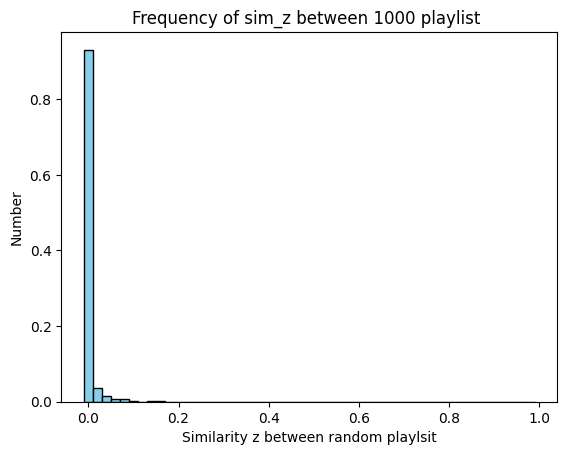

In [108]:
counts, bins = np.histogram(resz, bins=50, range=(0,1))
prob = counts / counts.sum()  # fraction de points par barre

plt.bar(bins[:-1], prob, width=bins[1]-bins[0], color='skyblue', edgecolor='black')
plt.xlabel("Similarity z between random playlsit")
plt.ylabel("Number")
plt.title("Frequency of sim_z between 1000 playlist ")
plt.savefig("histogram_similarityz.png", dpi=300)
plt.show()


In [ ]:
def get_tracks_artist(artist1):
    return  df_tracks_vectors.loc[
        df_tracks_vectors["artist_name"] == artist1,
        ["track_name", "pid","artist_name"]].compute().index.tolist()

def artist_sim(artist1, artist2):
    indices1 = get_tracks_artist(artist1)
    indices2 = get_tracks_artist(artist2)
    if not indices1 or not indices2: 
        return -1  # ou None
    
    return similar_tracks(indices1, indices2,0)


In [141]:
artist_sim("Damso","SCH")

In [ ]:
singer80 = [
    "Michael Jackson",
    "Madonna",
    "Prince",
    "Pat Benatar",
    "George Michael",
    "Bon Jovi",
    "David Bowie",
    "Phil Collins"
]
singer90 = [
    "Mariah Carey",
    "Britney Spears",
    "Whitney Houston",
    "Nirvana (Kurt Cobain)",
    "Madonna",
    "Dr. Dre",
    "Celine Dion"
]
singer2000 = [
    "Beyoncé",
    "Eminem",
    "Rihanna",
    "Usher",
    "Justin Timberlake",
    "Linkin Park",
    "Kanye West",
    "Lady Gaga",
]
singer2010 = [
    "Adele",
    "Bruno Mars",
    "Drake",
    "Ed Sheeran",
    "Katy Perry",
    "The Weeknd",
    "Billie Eilish",
    "Lady Gaga"
]
singer2020 = [
    "Billie Eilish",
    "Dua Lipa",
    "The Weeknd",
    "BTS",
    "Harry Styles",
    "Bad Bunny",
    "Taylor Swift",
    "Lizzo"
]

In [143]:
import itertools

1980s
1990s
2000s
2010s
2020s


ValueError: The 'color' keyword argument must have one color per dataset, but 28 datasets and 1 colors were provided

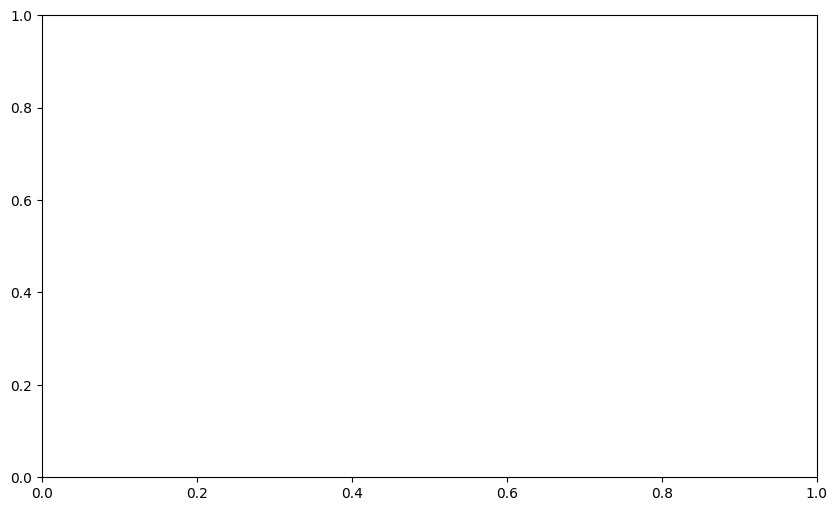

In [148]:
import itertools
decades = {
    "1980s": singer80,
    "1990s": singer90,
    "2000s": singer2000,
    "2010s": singer2010,
    "2020s": singer2020
}

# Stockage des similarités par décennie
sim_by_decade = {}

for decade, singers in decades.items():
    print(decade)
    sims = []
    # Toutes les paires possibles sans répétition
    for a1, a2 in itertools.combinations(singers, 2):
        sim = artist_sim(a1, a2)
        sims.append(sim)
    sim_by_decade[decade] = sims

# Plot
plt.figure(figsize=(10,6))
colors = ["red", "blue", "green", "orange", "purple"]

for color, (decade, sims) in zip(colors, sim_by_decade.items()):
    plt.hist(sims, bins=10, alpha=0.5, label=decade, color=color)

plt.xlabel("Artist Similarity")
plt.ylabel("Number of Pairs")
plt.title("Distribution of Artist Similarity by Decade")
plt.legend()
plt.show()


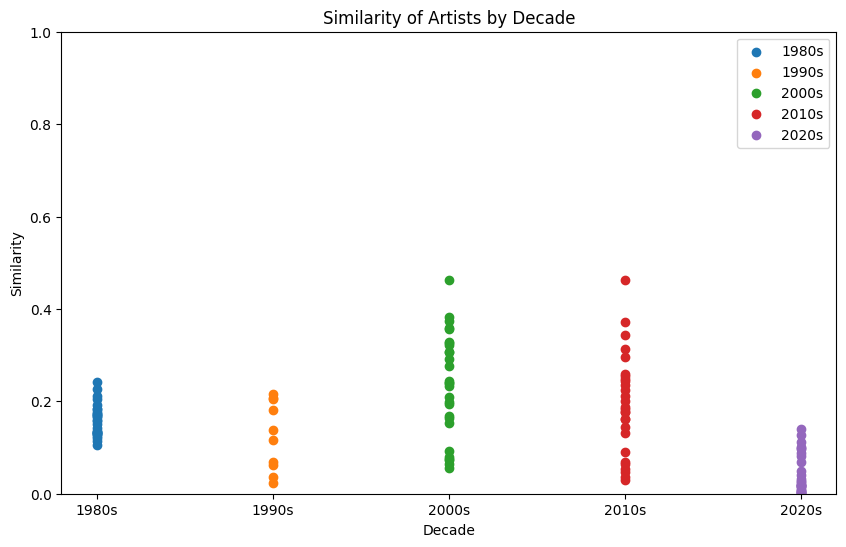

In [163]:
import matplotlib.pyplot as plt

# Décennies en x
x_labels = ["1980s", "1990s", "2000s", "2010s", "2020s"]
x = [1980, 1990, 2000, 2010, 2020]

# Extraire le premier élément de chaque tuple pour chaque décennie
y_values = [ [t[0] for t in sim_by_decade[decade] if t != -1]  for decade in x_labels ]

plt.figure(figsize=(10,6))

# Tracer chaque décennie
for xi, y_list, label in zip(x, y_values, x_labels):
    plt.scatter([xi]*len(y_list), y_list, label=label)  # tous les points sur la même x

plt.xlabel("Decade")
plt.ylabel("Similarity")
plt.title("Similarity of Artists by Decade")
plt.ylim(0,1)
plt.xticks(x, x_labels)
plt.legend()
plt.savefig("decades.png", dpi=300)
plt.show()


In [160]:
sim_by_decade['1980s']

[(0.2055314074558932, 0.0),
 (0.22633765637868528, 0.0),
 (0.15941103622491035, 0.0),
 (0.1838944544001718, 0.0),
 (0.21216906202956093, 0.0),
 (0.16637687734929849, 0.0),
 (0.17251575779231118, 0.0),
 (0.15835788426532066, 0.0),
 (0.16839625384978404, 0.0),
 (0.1772729986744336, 0.0),
 (0.13032080375223817, 0.0),
 (0.10494555521613082, 0.0),
 (0.12140509882960457, 0.0),
 (0.13093503944715237, 0.0),
 (0.1726670142611034, 0.0),
 (0.11478654316089659, 0.0),
 (0.14250797628000317, 0.0),
 (0.12421856225269592, 0.0),
 (0.1510208681485098, 0.0),
 (0.2417041720441994, 0.0),
 (0.13394702974292527, 0.0),
 (0.17147630071548675, 0.0),
 (0.13516736002120533, 0.0),
 (0.1289700276371823, 0.0),
 (0.18301068239477908, 0.0),
 (0.13166763389727967, 0.0),
 (0.1926301960879355, 0.0),
 (0.13361308865316962, 0.0)]

In [165]:
get_tracks_artist("Booba")

['08gKlkzii4ovitFMBF9td4',
 '09JIxnGQoSBNU0EatbbVsU',
 '0BXU5ogs9ULfbkAlV0GZ7S',
 '0HDGybB3ExQwM9ixnf5HP4',
 '0KK8HIybSFPJiJUKY238p1',
 '0KbuTaXtBVQGG1ZnhI3Rfd',
 '0YjijZe2KXN3Im4oQlbygG',
 '0ZxEcGMUJcngALV8aPkFTo',
 '0aD5LCDfVHHkh4ClKkjdRT',
 '0eeIjUTuPUBFYzZ7uSPuQP',
 '0expqXHym4w9NE5V9cz1yK',
 '0jUGvVQXbBGWREE3TLw3Xo',
 '0jeDIxRWOqBpuObWK87yJA',
 '0o45pddKK9LqllqbivEecx',
 '0uAUazosTqGLGiyvogPKuU',
 '0w1PC2pGG132CtAKPJCVdC',
 '0z328evnXZkVQhYnec9lCL',
 '0zw22D56UqMoouDHEp3d8p',
 '10M5NWwQ2QuWccafvppDHG',
 '14A9ile8l9naHC4U8H4uT5',
 '14Uw0AQI6LFWjuORh6oSwi',
 '19A3jB7lQakKeUl0vVdeST',
 '19BRPkqI4N18XHniTHM9fb',
 '1C0sYJfgA3by6SoR55cQxZ',
 '1CJPD1s1azOR9tS4bPZWyC',
 '1Jq6HzntBQcCgAG7RAGnbK',
 '1NBbjn7aJDlVodDOu7vvcV',
 '1OIu9tooUo7X6dVFPDCan9',
 '1blrKt9dJ10lyFrQcXhi9C',
 '1dksecV8jAtyIcDRhbjOPF',
 '1iDQ2zCOU1uYeR8QcpqUZb',
 '1nL4QzU2UPiklF2GHLBXUv',
 '1qQ8cvu61KQVsg1K3cSIgA',
 '1sKSVFcvU4bM5LsKZ1Q4P6',
 '1uFKIIkJGN04w6WaLiU0Nu',
 '1zBfKFRSGow9uHdGzmXB3B',
 '2A1tey7SKbz8NICUzuyMH1',
 

In [166]:
artist_sim("Booba", "Kaaris")

(0.25837616329344654, 0.0)

In [169]:
artist_sim("Iggy Pop","David Bowie")

(0.1359963957224845, 0.0)

In [168]:
get_tracks_artist("David Bowie")

['0067jQQPclCEKzCeI3qr3v',
 '03s8YuDpCn5aTJQrgPxzPi',
 '06edGFHYDwQb5rfpPd1EGZ',
 '07kRL6U0zXUWqcNjv1ETgl',
 '0DWsJi00CTyVCx3bpceXKk',
 '0E9NCtHE3pskS3njCW54fI',
 '0EvJV8yVsXX6CqETFCcQjc',
 '0JSqTE3MlK4ShOX31pqmut',
 '0RvXiZ9vvnjQjjMNIFfT6I',
 '0Tl9h5rQ1dGimsPcbwbrkD',
 '0VIYpIatSmesxU1AosvNCI',
 '0bskXv9qAUKLY9BZAHsVxr',
 '0cMsadaMprvueuOWPJ3eyh',
 '0i917YhkKoGjTChr8AlJO6',
 '0jK4d6gPbz61gLdnlnLoWL',
 '0tgDhblfwI3WAs7UCEfyAv',
 '17G8acTUbdbbd6DCmAi5Nb',
 '1FYzFosa0AxXmaUrx6wk4Q',
 '1HCjg24tAdkWboO6QCwkYS',
 '1JyJujVZBRA6nGAgqRzu4A',
 '1KtQPxHuFBBIp2k6KESce7',
 '1MZ6X6LSRdxqBlAls4JlGE',
 '1NDKwG5R7w2amVBYUjTaWk',
 '1NQIikRae2v6NdPrVSwj24',
 '1PIn9bQ6h7xfiZc3P4ryuM',
 '1WbRR38IdNzYoMCAF4BqdO',
 '1bVpMVHLU9TDB33l4CidIA',
 '1fyyDh4JhcMy2GOh8abFh2',
 '1g9f3gxyjGQMmBBh1csLUq',
 '1jECrkkSbnYHB7PyihYhL0',
 '1lV9vLXFC2X7cZEPSupXVd',
 '1lj1jm6vX27u510QmAyLWk',
 '1nVX3SwRfpmm580pCeECOP',
 '1oRYKOaSd9WtcgS03TAdCs',
 '1odbdHD5FPU4DYSR1dr2K9',
 '1p0P2eieaxzqeBov2oP1VQ',
 '1pmoFdnDWwfyxeOVPfMHrI',
 